# Overview

This document covers the generation of an event driven analysis of an AIM-format FSAE log using process mining.

## Code Overview

1. Generate events from the log (Ex: Engine RPM high, wide open throttle, max corner).
2. Select an event type of interest and draw a time boundary of +/- seconds around each event occurance.
3. Group all events within each boundary by a common trace ID
4. Perform the process mining
5. Visualize the Performance DF and Markov DF

## Use Cases
- Turn events from a checklist run into DFG graphs.
- Use case 1: (Fault Tree Analysis) Identify how failures cascade across a system (ex: from a minor fault to system failure)
- Use case 2: (Event Tree Analysis) Identify which events are related to each other for system debugging or analysis
- Use case 3: (Test and Verification) Identify if a system can meet a set of performance events, and identify what the deviations are and their behaviors.
- Use Case 4: (Timing analysis) Model the time changes between events, and the 1 sigma deviations to visualize what went through the flow in nominal time, and what traces resulted in longer than nominal.


In [87]:
# Import required packages and setup environment
import pandas as pd
import pandera.pandas as pa

filepath = "./data/raw/FSAE_Endurance_Full.csv"
parsed_filepath = "./data/processed/FSAE_Endurance_Full.csv"

In [88]:
df = pd.read_csv(
    parsed_filepath,
    encoding="latin1",
    low_memory=False,  # Read entire file at once
)

print(df.columns.to_list())

['time.lap_sec', 'distance_km', 'rr.shock_mm', 'rl.shock_mm', 'fl.shock_mm', 'fr.shock_mm', 'acc.lateral_g', 'acc.longitudin_g', 'rear.brake_psi', 'front.brake_psi', 'datalogger.tem_Â°f', 'battery_v', 'f88.rpm_rpm', 'f88.v.speed_mph', 'f88.d.speed_mph', 'f88.speed.fl_mph', 'f88.speed.fr_mph', 'f88.speed.rl_mph', 'f88.speed.rr_mph', 'f88.map1_mbar', 'f88.lambda1_a/f', 'f88.act1_Â°f', 'f88.ect1_Â°f', 'f88.gear_#', 'f88.oil.p1_psi', 'f88.v batt_v', 'f88.fuel.pr1_psi', 'f88.fuel.t_Â°f', 'f88.baro.pr_mbar', 'f88.tps1_%', 'f88.cal.switch_#', 'gps.speed_mph', 'gps.nsat_#', 'gps.latacc_g', 'gps.lonacc_g', 'gps.slope_deg', 'gps.heading_deg', 'gps.gyro_deg/s', 'gps.altitude_m', 'gps.posaccuracy_m', 'fl.shock.pos.zero_mm', 'fr.shock.pos.zero_mm', 'rl.shock.pos.zero_mm', 'rr.shock.pos.zero_mm', 'roll angle_unit', 'fr.roll.gradient_degree', 're.roll.gradient_degree', 'fl.shock.speed_mm/s', 'rr.shock.speed_mm/s', 'rl.shock.speed_mm/s', 'fr.shock.speed_mm/s', 'fl.bumpstop_unit', 'rr.bumpstop_unit', '

# Event conditions

Based on the telemetry columns, here are relevant event conditions for an FSAE team:
1. Lap Events (Fundamental)
Lap Started: lap increments, time.lap_sec resets to ~0
Lap Completed: time.lap_sec reaches max before reset
Sector Crossing: Based on distance_km or aim.distancemeters_m thresholds
2. Driver Performance Events
Braking Events:
Brake Applied: front.brake_psi or rear.brake_psi > threshold (e.g., 50 psi)
Hard Braking: rear.brake_psi > 400 psi AND acc.longitudin_g < -1.0g
Trail Braking: rear.brake_psi decreasing while acc.lateral_g > 0.5g
Brake Released: front.brake_psi < threshold
Cornering Events:
High Lateral Load: acc.lateral_g > 1.2g (aggressive cornering)
Corner Entry: acc.lateral_g increasing + speed decreasing
Corner Apex: acc.lateral_g at local max + gps.gyro_deg/s at max
Corner Exit: acc.lateral_g decreasing + f88.tps1_% increasing
Throttle Events:
Throttle Application: f88.tps1_% > 20%
Full Throttle: f88.tps1_% > 90%
Lift/Coast: f88.tps1_% < 10%
Wheel Spin: f88.d.speed_mph significantly > gps.speed_mph
3. Gear Shift Events
Upshift: f88.gear_# increases
Downshift: f88.gear_# decreases
Shift Under Load: Gear change while f88.tps1_% > 50%
Wrong Gear: f88.rpm_rpm outside optimal range for current gps.speed_mph
4. Suspension/Chassis Events
Bump/Compression:
Bumpstop Hit: fl.bumpstop_unit, fr.bumpstop_unit, etc. = 1 (binary)
Heavy Compression: Shock position (fl.shock_mm, etc.) > 80% travel
Bottoming Event: Max compression rate + bumpstop contact
Roll Event: roll angle_unit or fr.roll.gradient_degree > threshold
Surface Conditions:
Rough Surface: High variance in fl.shock.speed_mm/s or fl.shock.accel_mm/s/s
Jump/Airborne: All shock sensors show rapid extension simultaneously
5. Engine/Powertrain Events
Performance:
Launch: gps.speed_mph 0→moving + f88.tps1_% > 80%
Rev Limiter Hit: f88.rpm_rpm at max sustained value
Overrev: f88.rpm_rpm > safe threshold (e.g., 13,000 rpm)
Lugging: f88.rpm_rpm < 3000 + high load
Fuel System:
Fuel Starvation: f88.lambda1_a/f goes lean (>15) + f88.fuel.pr1_psi drops
Rich Condition: f88.lambda1_a/f < 12.5
High Fuel Flow: fuel flow_cc/min at maximum
6. Temperature Events
Engine Overheating: f88.ect1_°f > 220°F
Oil Overheating: f88.act1_°f > 280°F
Cooling Recovery: Temperature decreasing after peak
7. Pressure/Fluid Events
Low Oil Pressure: f88.oil.p1_psi < 30 psi (critical)
Oil Pressure Spike: run.oil.pres.hi_psi or load.oil.pres.hi_psi exceeds safe limit
Low Fuel Pressure: f88.fuel.pr1_psi < threshold
8. Electrical Events
Low Battery Voltage: battery_v or f88.v batt_v < 12.0V
Voltage Spike: battery_v > 15.0V
GPS Lock Lost: gps.nsat_# < 4
GPS Lock Acquired: gps.nsat_# >= 4
9. Calibration/Mode Events
Calibration Switch Change: f88.cal.switch_# changes value (e.g., rain mode, aggressive mode)
Map Change: f88.map1_mbar threshold changes suggest different tuning
10. Failure/Warning Events
Wheel Lockup: Individual wheel speed (f88.speed.fl_mph, etc.) drops to 0 while others moving
Loss of Traction: Rear wheel speeds >> front wheel speeds
Sensor Anomaly: Any sensor reading NaN, out of physical bounds
Data Logging Issue: cycle time_ms spikes (data acquisition lag)
11. Track Position Events
Straight Section: Low acc.lateral_g + high gps.speed_mph
Technical Section: High frequency f88.gear_# changes
Elevation Change: gps.slope_deg > threshold or gps.elevation_cm changing rapidly
12. Comparative/Session Events
Fastest Sector: Compare time.lap_sec at sector markers across laps
Consistency Check: Lap time variance
Setup Change: Between-run comparisons (different sessions in time.session_sec)


In [89]:
"""Event Extraction from FSAE Telemetry Data

This module extracts discrete events from continuous telemetry data based on
threshold conditions and state changes.

Considerations: Raw threshold-based methods on noisy telemetry can generate
spurious events. Consider adding hysteresis (different thresholds for entering vs. exiting 
a state) or minimum dwell times to avoid event flooding. Threshold-based detection works 
well for known failure modes but struggles with gradual drift or context-dependent anomalies.

"""

import numpy as np
import pandas as pd
from typing import List, Dict, Tuple


class EventExtractor:
    """Extract events from FSAE telemetry dataframe based on defined conditions."""

    def __init__(self, df: pd.DataFrame):
        """Initialize with telemetry dataframe.

        Args:
            df: Telemetry dataframe with all sensor channels
        """
        self.df = df
        self.events = []

    def detect_threshold_events(
        self,
        column: str,
        threshold: float,
        condition: str,
        event_name: str,
        min_duration_rows: int = 1,
    ) -> pd.DataFrame:
        """Detect events where a column crosses a threshold.

        Args:
            column: Column name to monitor
            threshold: Threshold value
            condition: Comparison operator ('>', '<', '>=', '<=', '==')
            event_name: Name of the event
            min_duration_rows: Minimum number of consecutive rows to confirm event

        Returns:
            DataFrame with columns: timestamp, event_name, value, lap
        """
        # Create boolean mask based on condition
        if condition == ">":
            mask = self.df[column] > threshold
        elif condition == "<":
            mask = self.df[column] < threshold
        elif condition == ">=":
            mask = self.df[column] >= threshold
        elif condition == "<=":
            mask = self.df[column] <= threshold
        elif condition == "==":
            mask = self.df[column] == threshold
        else:
            raise ValueError(f"Unknown condition: {condition}")

        # Find rising edges (transitions from False to True)
        rising_edge = mask & ~mask.shift(1).fillna(False)

        # Filter by minimum duration if specified
        if min_duration_rows > 1:
            # Check if condition stays true for min_duration_rows
            duration_check = pd.Series(False, index=self.df.index)
            for i in range(min_duration_rows):
                duration_check |= mask.shift(-i).fillna(False)
            rising_edge = rising_edge & duration_check

        # Extract events
        event_indices = self.df[rising_edge].index
        events_df = pd.DataFrame(
            {
                "timestamp": self.df.loc[event_indices, "time.absolute"],
                "activity": event_name,
                "value": self.df.loc[event_indices, column],
                "lap": self.df.loc[event_indices, "lap"],
                "session_time": self.df.loc[event_indices, "time.session_sec"],
            }
        )

        return events_df.reset_index(drop=True)

    def detect_state_change_events(
        self, column: str, event_name_prefix: str, ignore_nan: bool = True
    ) -> pd.DataFrame:
        """Detect when a column value changes (e.g., gear shifts, calibration changes).

        Args:
            column: Column name to monitor
            event_name_prefix: Prefix for event name (will append old->new values)
            ignore_nan: Whether to ignore NaN values

        Returns:
            DataFrame with event details
        """
        # Find where values change
        if ignore_nan:
            value_changed = (
                (self.df[column] != self.df[column].shift(1))
                & self.df[column].notna()
                & self.df[column].shift(1).notna()
            )
        else:
            value_changed = self.df[column] != self.df[column].shift(1)

        event_indices = self.df[value_changed].index

        events_df = pd.DataFrame(
            {
                "timestamp": self.df.loc[event_indices, "time.absolute"],
                "activity": [
                    f"{event_name_prefix} {self.df.loc[idx - 1, column]:.0f}->{self.df.loc[idx, column]:.0f}"
                    if idx > self.df.index[0]
                    else f"{event_name_prefix} Start"
                    for idx in event_indices
                ],
                "value": self.df.loc[event_indices, column],
                "lap": self.df.loc[event_indices, "lap"],
                "session_time": self.df.loc[event_indices, "time.session_sec"],
            }
        )

        return events_df.reset_index(drop=True)

    def detect_combined_condition_events(
        self,
        conditions: List[Tuple[str, str, float]],
        event_name: str,
        mode: str = "all",
    ) -> pd.DataFrame:
        """Detect events based on multiple conditions.

        Args:
            conditions: List of (column, operator, threshold) tuples
            event_name: Name of the event
            mode: 'all' (AND) or 'any' (OR) for combining conditions

        Returns:
            DataFrame with event details
        """
        masks = []
        for column, operator, threshold in conditions:
            if operator == ">":
                masks.append(self.df[column] > threshold)
            elif operator == "<":
                masks.append(self.df[column] < threshold)
            elif operator == ">=":
                masks.append(self.df[column] >= threshold)
            elif operator == "<=":
                masks.append(self.df[column] <= threshold)
            elif operator == "==":
                masks.append(self.df[column] == threshold)

        # Combine masks
        if mode == "all":
            combined_mask = pd.Series(True, index=self.df.index)
            for mask in masks:
                combined_mask &= mask
        else:  # 'any'
            combined_mask = pd.Series(False, index=self.df.index)
            for mask in masks:
                combined_mask |= mask

        # Find rising edges
        rising_edge = combined_mask & ~combined_mask.shift(1).fillna(False)
        event_indices = self.df[rising_edge].index

        events_df = pd.DataFrame(
            {
                "timestamp": self.df.loc[event_indices, "time.absolute"],
                "activity": event_name,
                "value": None,
                "lap": self.df.loc[event_indices, "lap"],
                "session_time": self.df.loc[event_indices, "time.session_sec"],
            }
        )

        return events_df.reset_index(drop=True)

    def detect_local_extrema_events(
        self,
        column: str,
        event_name_max: str,
        event_name_min: str,
        window_size: int = 10,
        prominence: float = 0.1,
    ) -> pd.DataFrame:
        """Detect local maxima and minima (e.g., corner apex).

        Args:
            column: Column to analyze
            event_name_max: Name for maximum events
            event_name_min: Name for minimum events
            window_size: Size of window for local comparison
            prominence: Minimum prominence (difference from neighbors)

        Returns:
            DataFrame with event details
        """
        from scipy.signal import find_peaks

        values = self.df[column].fillna(0).values

        # Find peaks (maxima)
        peaks_max, _ = find_peaks(values, distance=window_size, prominence=prominence)
        # Find valleys (minima)
        peaks_min, _ = find_peaks(-values, distance=window_size, prominence=prominence)

        # Create events for maxima
        events_max = pd.DataFrame(
            {
                "timestamp": self.df.iloc[peaks_max]["time.absolute"].values,
                "activity": event_name_max,
                "value": self.df.iloc[peaks_max][column].values,
                "lap": self.df.iloc[peaks_max]["lap"].values,
                "session_time": self.df.iloc[peaks_max]["time.session_sec"].values,
            }
        )

        # Create events for minima
        events_min = pd.DataFrame(
            {
                "timestamp": self.df.iloc[peaks_min]["time.absolute"].values,
                "activity": event_name_min,
                "value": self.df.iloc[peaks_min][column].values,
                "lap": self.df.iloc[peaks_min]["lap"].values,
                "session_time": self.df.iloc[peaks_min]["time.session_sec"].values,
            }
        )

        return pd.concat([events_max, events_min], ignore_index=True).sort_values(
            "timestamp"
        )


print("EventExtractor class defined successfully")

EventExtractor class defined successfully


In [90]:
# Initialize the event extractor
extractor = EventExtractor(df)

print(f"Event extractor initialized with {len(df)} telemetry rows")
print(
    f"Time range: {df['time.session_sec'].min():.2f}s to {df['time.session_sec'].max():.2f}s"
)
print(f"Number of laps: {df['lap'].max()}")

Event extractor initialized with 190587 telemetry rows
Time range: 0.01s to 1905.56s
Number of laps: 22


# Extract Events

Now we'll extract various types of events from the telemetry data using the EventExtractor class.

In [91]:
"""Extract all event types from telemetry data."""

all_events = []

# # 1. LAP EVENTS
# print("Extracting lap events...")
# lap_events = extractor.detect_state_change_events(
#     column='lap',
#     event_name_prefix='Lap'
# )
# all_events.append(lap_events)
# print(f"  Found {len(lap_events)} lap transitions")

# # 2. GEAR SHIFT EVENTS
# print("Extracting gear shift events...")
# gear_events = extractor.detect_state_change_events(
#     column='f88.gear_#',
#     event_name_prefix='Gear Shift'
# )
# all_events.append(gear_events)
# print(f"  Found {len(gear_events)} gear shifts")

# 3. BRAKING EVENTS
print("Extracting braking events...")
brake_applied = extractor.detect_threshold_events(
    column="front.brake_psi",
    threshold=50,
    condition=">",
    event_name="Brake Applied",
    min_duration_rows=3,
)
all_events.append(brake_applied)
print(f"  Found {len(brake_applied)} brake applications")

hard_braking = extractor.detect_combined_condition_events(
    conditions=[("rear.brake_psi", ">", 400), ("acc.longitudin_g", "<", -1.0)],
    event_name="Hard Braking",
    mode="all",
)
all_events.append(hard_braking)
print(f"  Found {len(hard_braking)} hard braking events")

# 4. THROTTLE EVENTS
print("Extracting throttle events...")
full_throttle = extractor.detect_threshold_events(
    column="f88.tps1_%",
    threshold=90,
    condition=">",
    event_name="Full Throttle",
    min_duration_rows=5,
)
all_events.append(full_throttle)
print(f"  Found {len(full_throttle)} full throttle events")

# 5. CORNERING EVENTS - Local maxima in lateral acceleration
print("Extracting cornering events...")
corner_events = extractor.detect_local_extrema_events(
    column="acc.lateral_g",
    event_name_max="Corner Apex (Left)",
    event_name_min="Corner Apex (Right)",
    window_size=20,
    prominence=0.3,
)
all_events.append(corner_events)
print(f"  Found {len(corner_events)} corner apex events")

# 6. HIGH LATERAL LOAD EVENTS
print("Extracting high lateral load events...")
high_lateral = extractor.detect_threshold_events(
    column="acc.lateral_g",
    threshold=1.2,
    condition=">",
    event_name="High Lateral Load",
    min_duration_rows=5,
)
all_events.append(high_lateral)
print(f"  Found {len(high_lateral)} high lateral load events")

# 7. BUMPSTOP EVENTS
print("Extracting suspension bumpstop events...")
for corner in ["fl", "fr", "rl", "rr"]:
    bumpstop = extractor.detect_threshold_events(
        column=f"{corner}.bumpstop_unit",
        threshold=0.5,
        condition=">",
        event_name=f"Bumpstop Hit ({corner.upper()})",
        min_duration_rows=1,
    )
    if len(bumpstop) > 0:
        all_events.append(bumpstop)
        print(f"  Found {len(bumpstop)} bumpstop hits on {corner.upper()}")

# 8. ENGINE EVENTS
print("Extracting engine events...")
high_rpm = extractor.detect_threshold_events(
    column="f88.rpm_rpm",
    threshold=11000,
    condition=">",
    event_name="High RPM",
    min_duration_rows=10,
)
all_events.append(high_rpm)
print(f"  Found {len(high_rpm)} high RPM events")

# 9. LOW OIL PRESSURE WARNING
print("Extracting oil pressure events...")
low_oil_pressure = extractor.detect_threshold_events(
    column="f88.oil.p1_psi",
    threshold=30,
    condition="<",
    event_name="Low Oil Pressure Warning",
    min_duration_rows=5,
)
if len(low_oil_pressure) > 0:
    all_events.append(low_oil_pressure)
    print(f"  Found {len(low_oil_pressure)} low oil pressure warnings")

# 10. GPS EVENTS
print("Extracting GPS events...")
gps_lock_lost = extractor.detect_threshold_events(
    column="gps.nsat_#",
    threshold=4,
    condition="<",
    event_name="GPS Lock Lost",
    min_duration_rows=10,
)
if len(gps_lock_lost) > 0:
    all_events.append(gps_lock_lost)
    print(f"  Found {len(gps_lock_lost)} GPS lock lost events")

print(f"\n{'=' * 60}")
print(f"Total event categories: {len(all_events)}")
print(f"Total events extracted: {sum(len(e) for e in all_events)}")

Extracting braking events...
  Found 373 brake applications
  Found 0 hard braking events
Extracting throttle events...
  Found 63 full throttle events
Extracting cornering events...
  Found 4122 corner apex events
Extracting high lateral load events...
  Found 1377 high lateral load events
Extracting suspension bumpstop events...
  Found 19 bumpstop hits on FL
  Found 19 bumpstop hits on FR
  Found 19 bumpstop hits on RL


/tmp/ipykernel_455045/1954472804.py:65: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  rising_edge = mask & ~mask.shift(1).fillna(False)
/tmp/ipykernel_455045/1954472804.py:72: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  duration_check |= mask.shift(-i).fillna(False)
/tmp/ipykernel_455045/1954472804.py:171: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcas

  Found 19 bumpstop hits on RR
Extracting engine events...
  Found 4 high RPM events
Extracting oil pressure events...
  Found 461 low oil pressure warnings
Extracting GPS events...

Total event categories: 11
Total events extracted: 6476


# Combine Events into Event Log

Merge all extracted events into a single event dataframe suitable for process mining.

In [92]:
# Combine all events into a single dataframe
events_df = pd.concat(all_events, ignore_index=True)

# Sort by timestamp
events_df = events_df.sort_values("timestamp").reset_index(drop=True)

# Add an event_id column
events_df.insert(0, "event_id", range(1, len(events_df) + 1))

# Add case_id (use lap number as case identifier)
events_df["case_id"] = "Lap_" + events_df["lap"].astype(int).astype(str)

# Reorder columns for clarity
events_df = events_df[
    ["event_id", "case_id", "timestamp", "activity", "lap", "session_time", "value"]
]

event_log_path = "./data/processed/FSAE_Event_Log.csv"
events_df.to_csv(event_log_path, index=False)

print(f"Combined Event Log Statistics:")
print(f"{'=' * 60}")
print(f"Total events: {len(events_df)}")
print(f"Unique activities: {events_df['activity'].nunique()}")
print(f"Unique cases (laps): {events_df['case_id'].nunique()}")
print(f"Time span: {events_df['timestamp'].min()} to {events_df['timestamp'].max()}")
print(f"\nEvent distribution by activity type:")
print(events_df["activity"].value_counts().head(15))
print(f"\nFirst 10 events:")
events_df.head(10)

Combined Event Log Statistics:
Total events: 6476
Unique activities: 11
Unique cases (laps): 22
Time span: 2016-05-14T16:27:26.010000Z to 2016-05-14T16:59:08.220000Z

Event distribution by activity type:
activity
Corner Apex (Right)         2070
Corner Apex (Left)          2052
High Lateral Load           1377
Low Oil Pressure Warning     461
Brake Applied                373
Full Throttle                 63
Bumpstop Hit (FL)             19
Bumpstop Hit (FR)             19
Bumpstop Hit (RL)             19
Bumpstop Hit (RR)             19
High RPM                       4
Name: count, dtype: int64

First 10 events:


/tmp/ipykernel_455045/2938048927.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  events_df = pd.concat(all_events, ignore_index=True)


,event_id,case_id,timestamp,activity,lap,session_time,value
0,1,Lap_1,2016-05-14T16:27:26.010000Z,Bumpstop Hit (FL),1,0.01,5.000000
1,2,Lap_1,2016-05-14T16:27:26.010000Z,Bumpstop Hit (FR),1,0.01,5.000000
2,3,Lap_1,2016-05-14T16:27:26.010000Z,Bumpstop Hit (RL),1,0.01,5.000000
3,4,Lap_1,2016-05-14T16:27:26.010000Z,Bumpstop Hit (RR),1,0.01,5.000000
4,5,Lap_1,2016-05-14T16:27:26.010000Z,Low Oil Pressure Warning,1,0.01,0.000000
5,6,Lap_1,2016-05-14T16:27:27.930000Z,Bumpstop Hit (FR),1,1.93,2.000000
6,7,Lap_1,2016-05-14T16:27:27.930000Z,Bumpstop Hit (RL),1,1.93,2.000000
7,8,Lap_1,2016-05-14T16:27:27.930000Z,Bumpstop Hit (RR),1,1.93,2.000000
8,9,Lap_1,2016-05-14T16:27:27.930000Z,Bumpstop Hit (FL),1,1.93,2.000000
9,10,Lap_1,2016-05-14T16:27:52.570000Z,Low Oil Pressure Warning,1,26.57,29.161869


# Time Window Case Generator

Create process mining cases based on time windows around specific events of interest.

This allows you to analyze what happens before and after critical events (e.g., analyze the 5 seconds before and 10 seconds after each hard braking event).

**Key Concept**: Instead of using laps as cases, we create cases centered around specific events with configurable time windows.

In [93]:
"""Time Window Case Generator

This class generates process mining cases by creating time windows around
events of interest. Events can belong to multiple cases if time windows overlap.
"""

import pandas as pd
from typing import Optional, List, Union


class TimeWindowCaseGenerator:
    """Generate case IDs based on time windows around specific events."""

    def __init__(self, event_log: pd.DataFrame):
        """Initialize with an event log dataframe.

        Args:
            event_log: DataFrame with columns including 'timestamp', 'activity', 'session_time'
        """
        self.event_log = event_log.copy()

        # Ensure session_time is available
        if "session_time" not in self.event_log.columns:
            raise ValueError("event_log must contain 'session_time' column")

        # Ensure events are sorted by time
        self.event_log = self.event_log.sort_values("session_time").reset_index(
            drop=True
        )

        print(f"TimeWindowCaseGenerator initialized with {len(self.event_log)} events")

    def generate_cases(
        self,
        trigger_event: Union[str, List[str]],
        time_before: float,
        time_after: float,
        case_prefix: str = "Case",
    ) -> pd.DataFrame:
        """Generate cases based on time windows around trigger events.

        This method finds all occurrences of the trigger event(s) and creates a time
        window around each occurrence. All events within each time window are assigned
        to that case. Events can appear in multiple cases if windows overlap.

        Args:
            trigger_event: Activity name(s) to use as trigger. Can be a string or list of strings.
            time_before: Time window before the trigger event (in seconds)
            time_after: Time window after the trigger event (in seconds)
            case_prefix: Prefix for case IDs (default: "Case")

        Returns:
            New DataFrame with events assigned to time window cases.
            Each row represents an event-case assignment.
        """
        # Convert single trigger to list
        if isinstance(trigger_event, str):
            trigger_events = [trigger_event]
        else:
            trigger_events = trigger_event

        # Find all trigger event occurrences
        trigger_mask = self.event_log["activity"].isin(trigger_events)
        trigger_occurrences = self.event_log[trigger_mask].copy()

        if len(trigger_occurrences) == 0:
            print(f"Warning: No events found matching trigger: {trigger_events}")
            return pd.DataFrame()

        print(f"Found {len(trigger_occurrences)} trigger event occurrences")
        print(f"Time window: -{time_before}s to +{time_after}s around each trigger")

        # Create cases for each trigger occurrence
        case_events = []

        for idx, (trigger_idx, trigger_row) in enumerate(
            trigger_occurrences.iterrows()
        ):
            case_id = f"{case_prefix}_{idx + 1:04d}"
            trigger_time = trigger_row["session_time"]

            # Define time window
            window_start = trigger_time - time_before
            window_end = trigger_time + time_after

            # Find all events within this time window
            in_window = (self.event_log["session_time"] >= window_start) & (
                self.event_log["session_time"] <= window_end
            )

            window_events = self.event_log[in_window].copy()

            # Add case information
            window_events["case_id"] = case_id
            window_events["trigger_event"] = trigger_row["activity"]
            window_events["trigger_time"] = trigger_time
            window_events["window_start"] = window_start
            window_events["window_end"] = window_end
            window_events["time_relative_to_trigger"] = (
                window_events["session_time"] - trigger_time
            )
            window_events["is_trigger"] = window_events.index == trigger_idx

            case_events.append(window_events)

        # Combine all cases into a single dataframe
        result_df = pd.concat(case_events, ignore_index=True)

        # Sort by case_id and then by time within each case
        result_df = result_df.sort_values(["case_id", "session_time"]).reset_index(
            drop=True
        )

        # Add sequence number within each case
        result_df["event_sequence"] = result_df.groupby("case_id").cumcount() + 1

        print(f"\nGenerated {len(trigger_occurrences)} cases")
        print(f"Total event-case assignments: {len(result_df)}")
        print(
            f"Average events per case: {len(result_df) / len(trigger_occurrences):.1f}"
        )

        # Calculate overlap statistics
        original_events = len(self.event_log)
        unique_events_in_cases = result_df.index.nunique()

        if original_events > 0:
            overlap_ratio = (
                len(result_df) / unique_events_in_cases
                if unique_events_in_cases > 0
                else 0
            )
            print(
                f"Event overlap ratio: {overlap_ratio:.2f}x (events appear in multiple cases)"
            )

        return result_df

    def get_case_summary(self, case_df: pd.DataFrame) -> pd.DataFrame:
        """Get summary statistics for each case.

        Args:
            case_df: DataFrame returned from generate_cases()

        Returns:
            DataFrame with one row per case containing summary statistics
        """
        summary = case_df.groupby("case_id").agg(
            {
                "activity": "count",  # Number of events
                "session_time": ["min", "max"],  # Time range
                "trigger_event": "first",
                "trigger_time": "first",
            }
        )

        summary.columns = [
            "event_count",
            "start_time",
            "end_time",
            "trigger_event",
            "trigger_time",
        ]
        summary["duration"] = summary["end_time"] - summary["start_time"]
        summary = summary.reset_index()

        return summary

    def visualize_case_windows(
        self, case_df: pd.DataFrame, max_cases: int = 20, figsize: tuple = (15, 8)
    ):
        """Visualize time windows and event distribution across cases.

        Args:
            case_df: DataFrame returned from generate_cases()
            max_cases: Maximum number of cases to show (default: 20)
            figsize: Figure size tuple (default: (15, 8))
        """
        import matplotlib.pyplot as plt
        import matplotlib.patches as mpatches

        # Get unique cases
        cases = case_df["case_id"].unique()[:max_cases]

        fig, axes = plt.subplots(2, 1, figsize=figsize)

        # Plot 1: Timeline of cases showing windows
        ax1 = axes[0]
        for i, case_id in enumerate(cases):
            case_data = case_df[case_df["case_id"] == case_id].iloc[0]

            # Draw window
            window_start = case_data["window_start"]
            window_end = case_data["window_end"]
            trigger_time = case_data["trigger_time"]

            ax1.barh(
                i,
                window_end - window_start,
                left=window_start,
                height=0.8,
                alpha=0.3,
                color="blue",
                edgecolor="black",
            )

            # Mark trigger event
            ax1.plot(trigger_time, i, "r*", markersize=12, zorder=10)

        ax1.set_yticks(range(len(cases)))
        ax1.set_yticklabels(cases, fontsize=8)
        ax1.set_xlabel("Session Time (seconds)")
        ax1.set_ylabel("Case ID")
        ax1.set_title("Time Windows for Each Case (Red star = Trigger Event)")
        ax1.grid(True, alpha=0.3, axis="x")

        # Plot 2: Event distribution within cases
        ax2 = axes[1]
        activity_counts = (
            case_df.groupby(["case_id", "activity"]).size().unstack(fill_value=0)
        )

        # Show top N most frequent activities
        top_activities = case_df["activity"].value_counts().head(10).index
        activity_counts_subset = activity_counts[
            [col for col in top_activities if col in activity_counts.columns]
        ]

        activity_counts_subset.iloc[:max_cases].plot(kind="barh", stacked=True, ax=ax2)
        ax2.set_xlabel("Number of Events")
        ax2.set_ylabel("Case ID")
        ax2.set_title("Event Distribution by Activity Type (Top 10 Activities)")
        ax2.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)

        plt.tight_layout()
        return fig


print("TimeWindowCaseGenerator class defined successfully")

TimeWindowCaseGenerator class defined successfully


# Example 1: Analyze Full Throttle Events

Let's create cases around "Full Throttle" events to see what happens before and after the driver goes full throttle.

In [ ]:
# Initialize the case generator
case_gen = TimeWindowCaseGenerator(events_df)

# Generate cases around Full Throttle events
# Look at 3 seconds before and 5 seconds after each full throttle application
throttle_cases = case_gen.generate_cases(
    trigger_event="Full Throttle",
    time_before=0.0,  # 0 seconds before
    time_after=5.0,  # 5 seconds after
    case_prefix="FullThrottle",
)

print(f"\n{'=' * 60}")
print("First case example:")
first_case = throttle_cases[throttle_cases["case_id"] == "FullThrottle_0001"]
print(
    first_case[["event_sequence", "activity", "time_relative_to_trigger", "is_trigger"]]
)

TimeWindowCaseGenerator initialized with 6476 events
Found 63 trigger event occurrences
Time window: -0.0s to +5.0s around each trigger

Generated 63 cases
Total event-case assignments: 1281
Average events per case: 20.3
Event overlap ratio: 1.00x (events appear in multiple cases)

Sample of generated cases:


,event_id,case_id,timestamp,activity,lap,session_time,value,trigger_event,trigger_time,window_start,window_end,time_relative_to_trigger,is_trigger,event_sequence
0,23,FullThrottle_0001,2016-05-14T16:28:28.740000Z,Full Throttle,1,62.74,91.280006,Full Throttle,62.74,62.74,67.74,0.00,True,1
1,24,FullThrottle_0001,2016-05-14T16:28:29.330000Z,High RPM,1,63.33,11066.000000,Full Throttle,62.74,62.74,67.74,0.59,False,2
2,25,FullThrottle_0001,2016-05-14T16:28:29.860000Z,Corner Apex (Left),1,63.86,0.268492,Full Throttle,62.74,62.74,67.74,1.12,False,3
3,26,FullThrottle_0001,2016-05-14T16:28:31.630000Z,Corner Apex (Left),1,65.63,-0.897666,Full Throttle,62.74,62.74,67.74,2.89,False,4
4,27,FullThrottle_0001,2016-05-14T16:28:31.730000Z,Corner Apex (Right),1,65.73,-1.743186,Full Throttle,62.74,62.74,67.74,2.99,False,5
5,28,FullThrottle_0001,2016-05-14T16:28:31.900000Z,High Lateral Load,1,65.90,1.312567,Full Throttle,62.74,62.74,67.74,3.16,False,6
6,29,FullThrottle_0001,2016-05-14T16:28:31.950000Z,High Lateral Load,1,65.95,1.218647,Full Throttle,62.74,62.74,67.74,3.21,False,7
7,30,FullThrottle_0001,2016-05-14T16:28:32.010000Z,Corner Apex (Left),1,66.01,1.473812,Full Throttle,62.74,62.74,67.74,3.27,False,8
8,31,FullThrottle_0001,2016-05-14T16:28:32.130000Z,Corner Apex (Right),1,66.13,-0.362288,Full Throttle,62.74,62.74,67.74,3.39,False,9
9,32,FullThrottle_0001,2016-05-14T16:28:32.320000Z,Corner Apex (Left),1,66.32,0.395020,Full Throttle,62.74,62.74,67.74,3.58,False,10


# Example 2: Analyze Bumpstop Events

Create cases around suspension bumpstop hits to understand what leads to bottoming out.

In [ ]:
# Generate cases around any bumpstop hit (all 4 corners)
bumpstop_triggers = [
    "Bumpstop Hit (FL)",
    "Bumpstop Hit (FR)",
    "Bumpstop Hit (RL)",
    "Bumpstop Hit (RR)",
]

bumpstop_cases = case_gen.generate_cases(
    trigger_event=bumpstop_triggers,
    time_before=5.0,  # 5 seconds before
    time_after=0.0,  # 0 seconds after
    case_prefix="Bumpstop",
)

print(f"\n{'=' * 60}")
print("First case example:")
first_case = bumpstop_cases[bumpstop_cases["case_id"] == "Bumpstop_0001"]
print(
    first_case[["event_sequence", "activity", "time_relative_to_trigger", "is_trigger"]]
)

Found 76 trigger event occurrences
Time window: -3.0s to +0.0s around each trigger

Generated 76 cases
Total event-case assignments: 440
Average events per case: 5.8
Event overlap ratio: 1.00x (events appear in multiple cases)

First case example:
   event_sequence                  activity  time_relative_to_trigger  \
0               1         Bumpstop Hit (FL)                       0.0   
1               2         Bumpstop Hit (FR)                       0.0   
2               3         Bumpstop Hit (RL)                       0.0   
3               4         Bumpstop Hit (RR)                       0.0   
4               5  Low Oil Pressure Warning                       0.0   

   is_trigger  
0        True  
1       False  
2       False  
3       False  
4       False  


# Export Cases for Process Mining

Save the case-based event logs for use with PM4PY or other process mining tools.

In [96]:
# Save all case-based event logs
output_dir = "./data/processed/"

# Full throttle cases
throttle_path = f"{output_dir}cases_full_throttle.csv"
throttle_cases.to_csv(throttle_path, index=False)
print(f"Full Throttle cases saved to: {throttle_path}")

# Bumpstop cases
bumpstop_path = f"{output_dir}cases_bumpstop.csv"
bumpstop_cases.to_csv(bumpstop_path, index=False)
print(f"Bumpstop cases saved to: {bumpstop_path}")

Full Throttle cases saved to: ./data/processed/cases_full_throttle.csv
Bumpstop cases saved to: ./data/processed/cases_bumpstop.csv


# Process Mining Analysis on Throttle Cases

Now we'll use PM4PY to analyze the Full Throttle cases and discover event patterns.

In [97]:
import pm4py
from IPython.display import display, Image

# Format the throttle_cases dataframe for PM4PY
# PM4PY requires specific column names: case_id, activity, timestamp
throttle_df_pm4py = pm4py.format_dataframe(
    throttle_cases,
    case_id="case_id",
    activity_key="activity",
    timestamp_key="timestamp",
)

# Convert to event log
throttle_event_log = pm4py.convert_to_event_log(throttle_df_pm4py)

print(f"PM4PY Event Log Created:")
print(f"  Number of cases: {len(throttle_event_log)}")
print(f"  Number of events: {sum(len(case) for case in throttle_event_log)}")
print(
    f"  Number of unique activities: {len(set(event['concept:name'] for case in throttle_event_log for event in case))}"
)

# Display first few events of first case
print(f"\nFirst case preview:")
first_case = throttle_event_log[0]
for i, event in enumerate(first_case[:10]):
    print(f"  {i + 1}. {event['concept:name']} at {event['time:timestamp']}")

PM4PY Event Log Created:
  Number of cases: 63
  Number of events: 1281
  Number of unique activities: 7

First case preview:
  1. Full Throttle at 2016-05-14 16:28:28.740000+00:00
  2. High RPM at 2016-05-14 16:28:29.330000+00:00
  3. Corner Apex (Left) at 2016-05-14 16:28:29.860000+00:00
  4. Corner Apex (Left) at 2016-05-14 16:28:31.630000+00:00
  5. Corner Apex (Right) at 2016-05-14 16:28:31.730000+00:00
  6. High Lateral Load at 2016-05-14 16:28:31.900000+00:00
  7. High Lateral Load at 2016-05-14 16:28:31.950000+00:00
  8. Corner Apex (Left) at 2016-05-14 16:28:32.010000+00:00
  9. Corner Apex (Right) at 2016-05-14 16:28:32.130000+00:00
  10. Corner Apex (Left) at 2016-05-14 16:28:32.320000+00:00


## Performance DFG (Directly-Follows Graph)

This shows the flow of events with **timing information** - how long it typically takes to go from one event to the next.

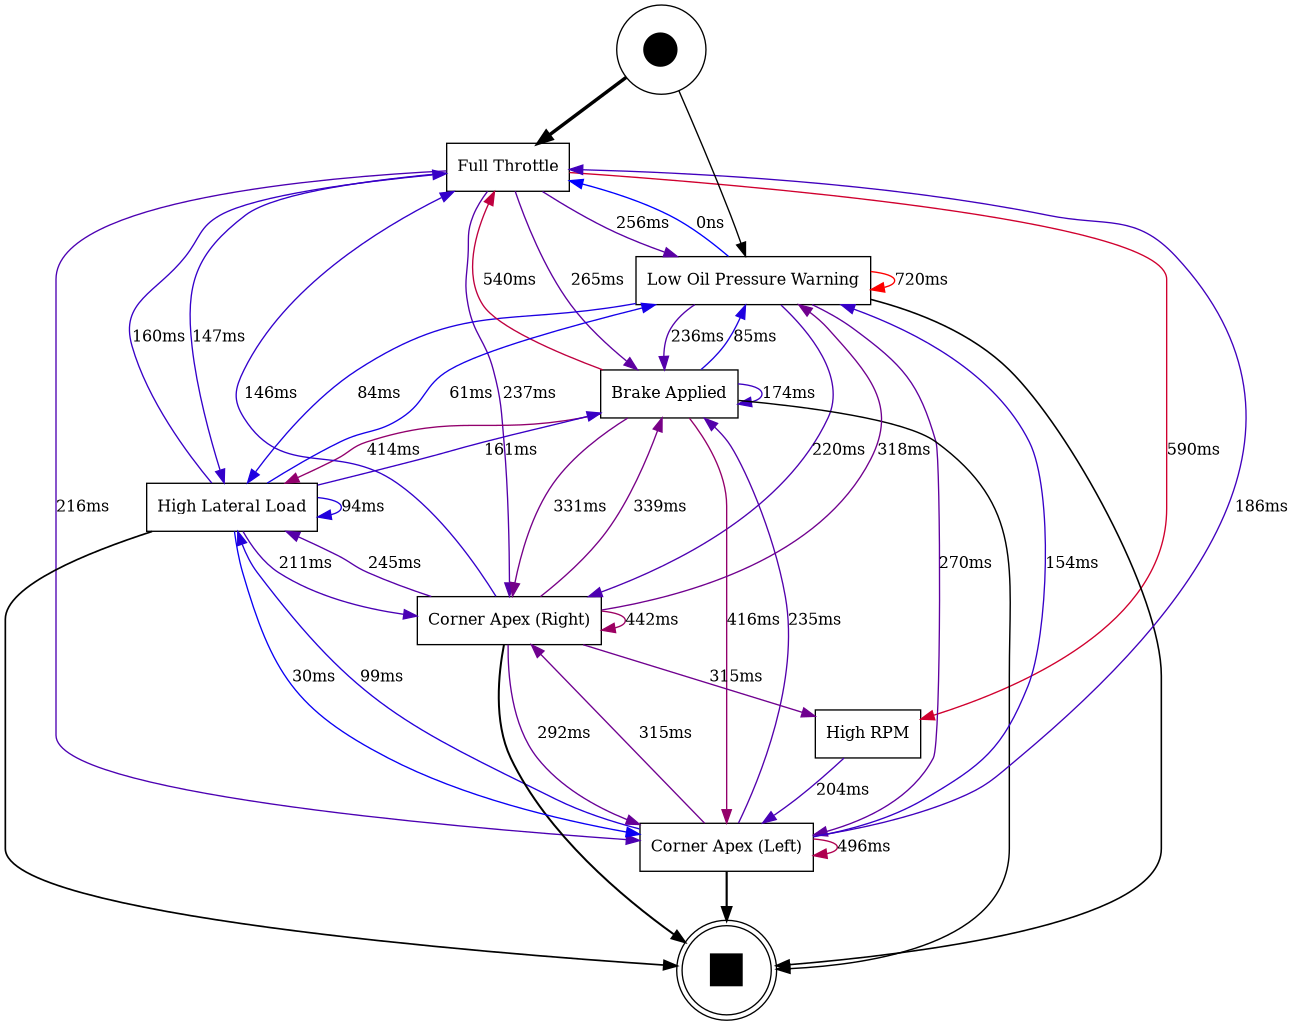

In [98]:
# Discover performance DFG - returns tuple (dfg_dict, start_activities, end_activities)
dfg_perf, sa_perf, ea_perf = pm4py.discover_performance_dfg(throttle_event_log)

# Visualize with performance (time) annotations
perf_filename = "./data/processed/throttle_cases_dfg_performance.png"
pm4py.save_vis_performance_dfg(
    dfg_perf, sa_perf, ea_perf, str(perf_filename), rankdir="TB"
)

display(Image(perf_filename, width=1000))

## Markov Chain DFG (Frequency-based)

This shows the flow of events with **frequency information** - how often each path is taken (like a Markov chain transition probability).

Markov DFG saved to: ./data/processed/throttle_cases_dfg_markov.png


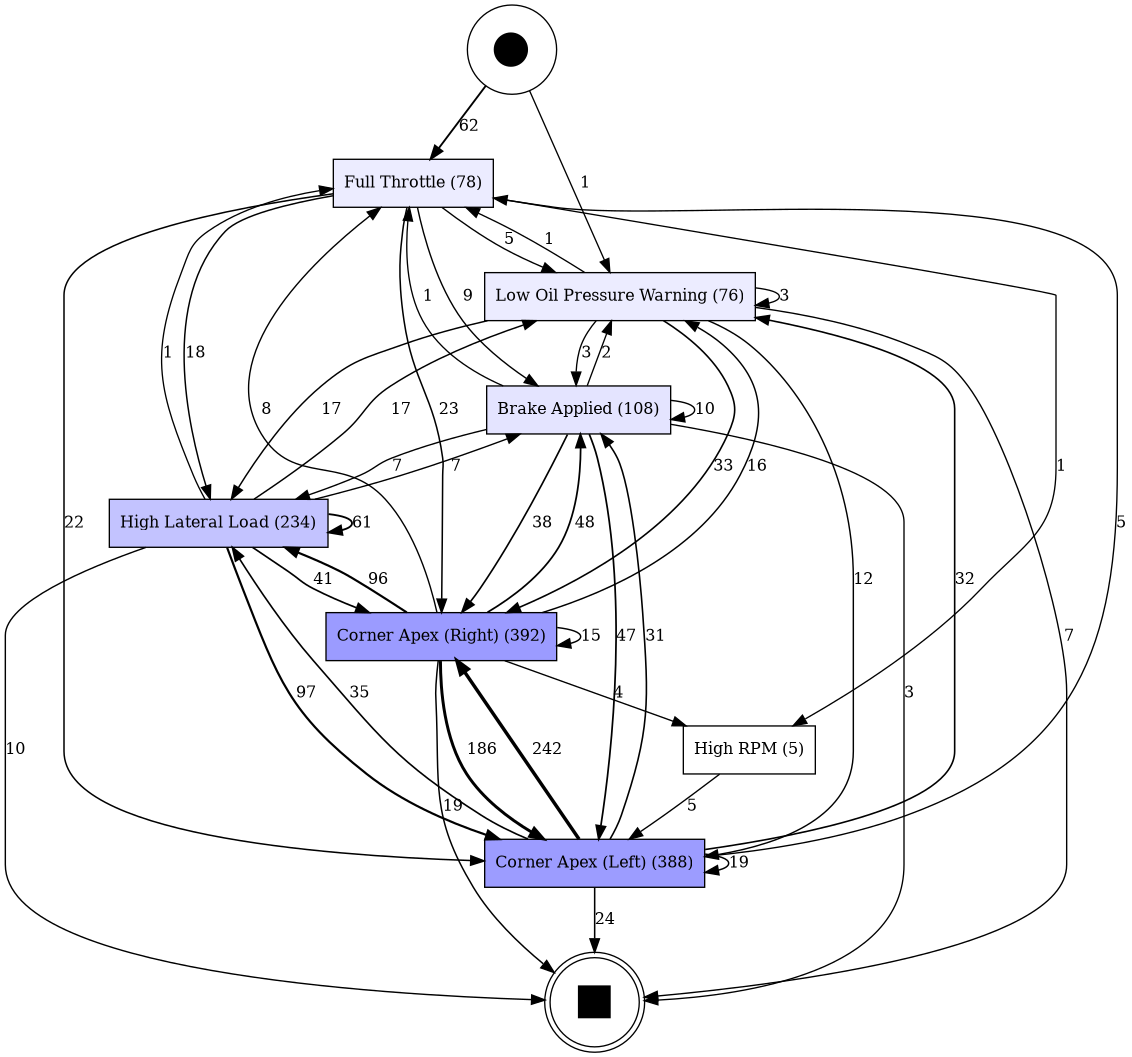

In [99]:
"""Generate a Directly-Follows Graph as a Markov chain, visualizing the variant flows."""

# Discover DFG with frequency annotations
dfg_markov, sa_markov, ea_markov = pm4py.discover_directly_follows_graph(
    throttle_event_log
)

# Visualize with frequency annotations
markov_filename = "./data/processed/throttle_cases_dfg_markov.png"
pm4py.save_vis_dfg(dfg_markov, sa_markov, ea_markov, str(markov_filename), rankdir="TB")
print(f"Markov DFG saved to: {markov_filename}")

display(Image(markov_filename, width=1000))

## Analyze the bottom out events using process mining

In [100]:

# Format the throttle_cases dataframe for PM4PY
# PM4PY requires specific column names: case_id, activity, timestamp
throttle_df_pm4py = pm4py.format_dataframe(
    bumpstop_cases,
    case_id="case_id",
    activity_key="activity",
    timestamp_key="timestamp",
)

# Convert to event log
bumpstop_event_log = pm4py.convert_to_event_log(throttle_df_pm4py)

print(f"PM4PY Event Log Created:")
print(f"  Number of cases: {len(bumpstop_event_log)}")
print(f"  Number of events: {sum(len(case) for case in bumpstop_event_log)}")
print(
    f"  Number of unique activities: {len(set(event['concept:name'] for case in bumpstop_event_log for event in case))}"
)

# Display first few events of first case
print(f"\nFirst case preview:")
first_case = bumpstop_event_log[0]
for i, event in enumerate(first_case[:10]):
    print(f"  {i + 1}. {event['concept:name']} at {event['time:timestamp']}")

PM4PY Event Log Created:
  Number of cases: 76
  Number of events: 440
  Number of unique activities: 6

First case preview:
  1. Bumpstop Hit (FL) at 2016-05-14 16:27:26.010000+00:00
  2. Bumpstop Hit (FR) at 2016-05-14 16:27:26.010000+00:00
  3. Bumpstop Hit (RL) at 2016-05-14 16:27:26.010000+00:00
  4. Bumpstop Hit (RR) at 2016-05-14 16:27:26.010000+00:00
  5. Low Oil Pressure Warning at 2016-05-14 16:27:26.010000+00:00


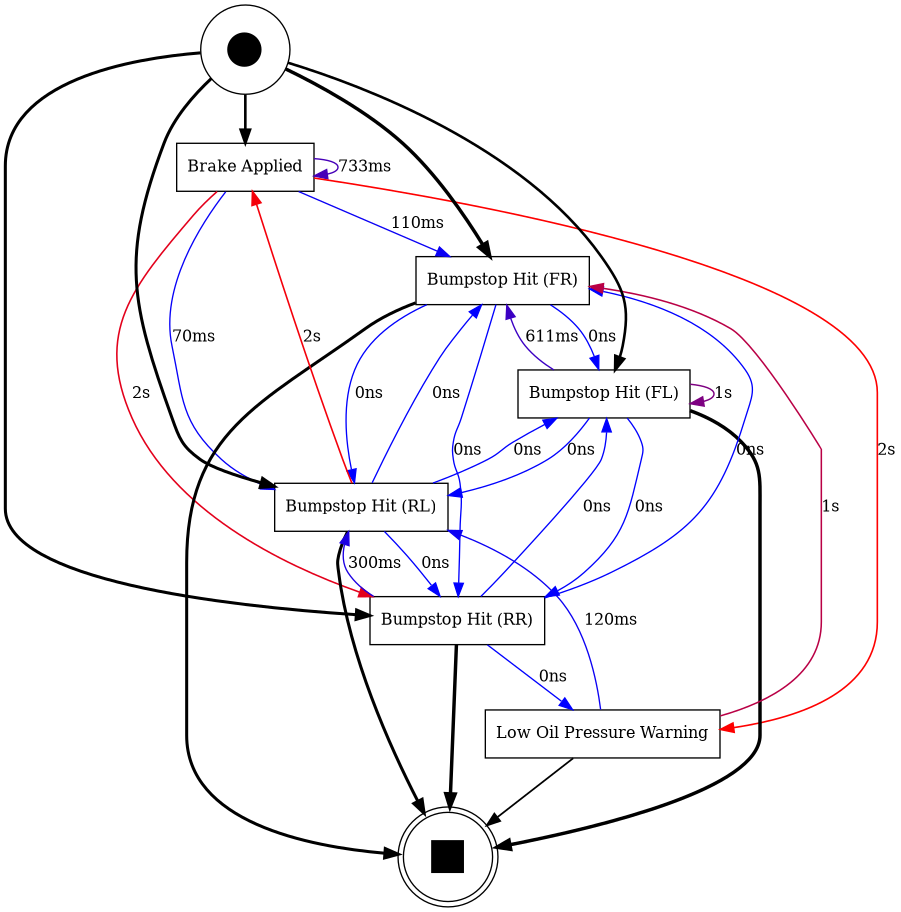

In [101]:
# Discover performance DFG - returns tuple (dfg_dict, start_activities, end_activities)
dfg_perf, sa_perf, ea_perf = pm4py.discover_performance_dfg(bumpstop_event_log)

# Visualize with performance (time) annotations
perf_filename = "./data/processed/bumpstop_cases_dfg_performance.png"
pm4py.save_vis_performance_dfg(
    dfg_perf, sa_perf, ea_perf, str(perf_filename), rankdir="TB"
)

display(Image(perf_filename, width=1000))

Markov DFG saved to: ./data/processed/bumpstop_cases_dfg_markov.png


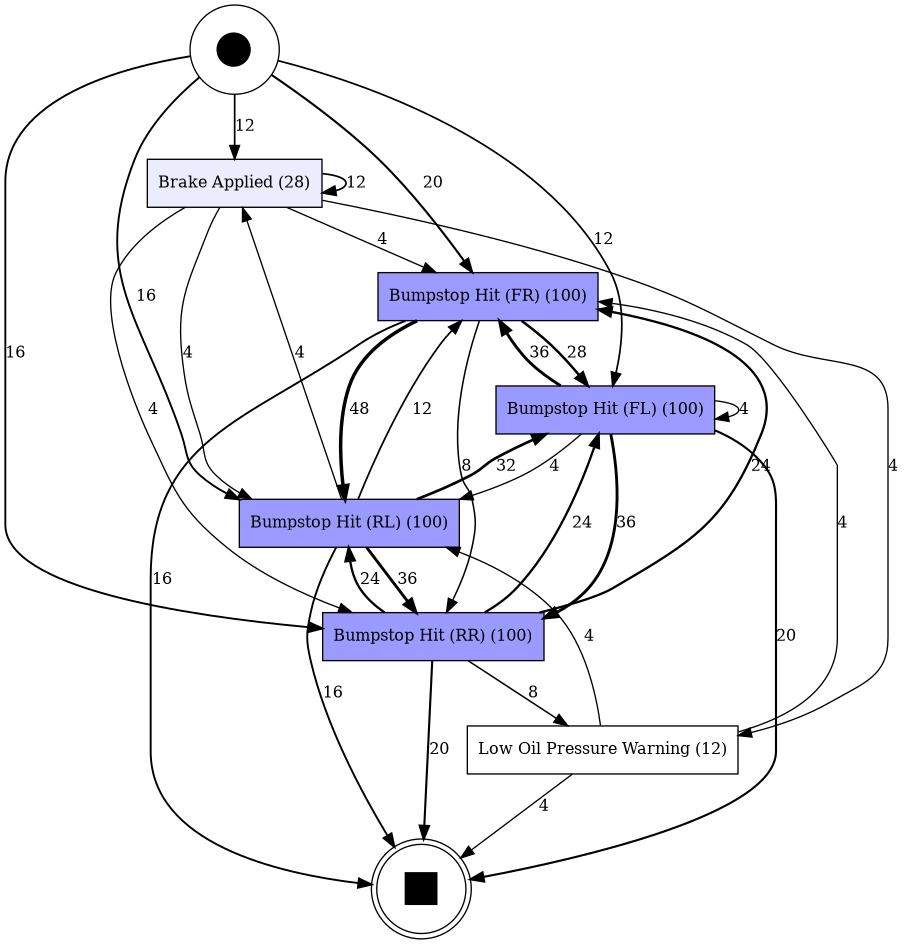

In [102]:
"""Generate a Directly-Follows Graph as a Markov chain, visualizing the variant flows."""

# Discover DFG with frequency annotations
dfg_markov, sa_markov, ea_markov = pm4py.discover_directly_follows_graph(
    bumpstop_event_log
)

# Visualize with frequency annotations
markov_filename = "./data/processed/bumpstop_cases_dfg_markov.png"
pm4py.save_vis_dfg(dfg_markov, sa_markov, ea_markov, str(markov_filename), rankdir="TB")
print(f"Markov DFG saved to: {markov_filename}")

display(Image(markov_filename, width=1000))